# Fancy kerstkaartjes
Fancy kerstkaartjes o.b.v. OSM data rond de woonplaats.<br>
Dries Verdoodt & Inne Vanderkelen<br>
13/11/2020<br>

Inspiration by: https://ggplot2tutor.com/streetmaps/streetmaps/

In [1]:
import ogr
import shapely
from shapely.geometry import *
from pyproj import Proj, Transformer, CRS
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import requests
import json

## Set variables and functions

In [2]:
driver = ogr.GetDriverByName("OSM")
inProj = CRS('EPSG:4326')
outProj = CRS('epsg:31370')
transformer = Transformer.from_crs("epsg:4326", "epsg:31370")

## Nederland
#outProj = CRS('epsg:28992')
#transformer = Transformer.from_crs("epsg:4326", "epsg:28992")

## Spanje
#outProj = CRS('epsg:2062')
#transformer = Transformer.from_crs("epsg:4326", "epsg:2062")

In [15]:
# Define a dictionary with locations and boudning boxes in LB72 coordinates
# Define the zoom factor as a factor of 1. Smaller than 1 means zoom in. Higher than 1 means zoom out.
locaties = {
    'Aarschot':  {'center': (50.9846, 4.8279), 'zoom_factor':3 , 'orientation':'portrait', 'title': 'A A R S C H O T'},
    'Lier':      {'center': (51.1331, 4.5696), 'zoom_factor':2.5 , 'orientation':'portrait', 'title': 'L I E R'},
    'Gent':      {'center': (51.0462, 3.7273), 'zoom_factor': 2.5, 'orientation':'portrait', 'title': 'G E N T'} ,
    'Mechelen':  {'center': (51.0263, 4.4810), 'zoom_factor':1.2 , 'orientation':'portrait', 'title': 'M E C H E L E N'},
    'Brussel':   {'center': (50.8450, 4.3562), 'zoom_factor':2.5 , 'orientation':'portrait', 'title': 'B R U S S E L'},
    'Antwerpen': {'center': (51.2116, 4.4125), 'zoom_factor':3.15 , 'orientation': 'portrait', 'title': 'A N T W E R P E N'},
    'Leuven':    {'center': (50.8774, 4.6981), 'zoom_factor':1.8 , 'orientation':'portrait', 'title': 'L E U V E N'},
    'Aalst':     {'center': (50.9338, 4.0368), 'zoom_factor':1.85 , 'orientation':'portrait', 'title': 'A A L S T'},
    'Tienen':    {'center': (50.8074, 4.9366), 'zoom_factor':2.25 , 'orientation':'landscape', 'title': 'T I E N E N'}
}

locaties = {
#    'Amsterdam_small': {'center': (52.36841209677118, 4.899131445525048), 'zoom_factor':2.2 , 'orientation':'landscape', 'title': 'A M S T E R D A M'}
#   'Amsterdam': {'center': (52.3717933,4.8759073), 'zoom_factor':2.70 , 'orientation':'landscape', 'title': 'A M S T E R D A M'}
    'Barcelona': {'center': (41.3526541,2.1282716), 'zoom_factor':9 , 'orientation':'portrait', 'title': 'B A R C E L O N A'}
}

locaties = {
    'Zottegem':  {'center': (50.8680, 3.8098), 'zoom_factor': 2, 'orientation':'landscape', 'title': 'Z O T T E G E M'},
    'Opwijk':    {'center': (50.9621, 4.1785), 'zoom_factor': 2.1, 'orientation':'portrait', 'title': 'O P W I J K'},
    'Lebbeke':   {'center': (50.9973, 4.1342), 'zoom_factor': 2, 'orientation':'portrait', 'title': 'L E B B E K E'},
#    'Baardegem': {'center': (50.9536, 4.1364), 'zoom_factor': 1.75, 'orientation':'portrait', 'title': 'B A A R D E G E M'},
    'Mazenzele': {'center': (50.9485, 4.1729), 'zoom_factor': 1.5, 'orientation':'portrait', 'title': 'M A Z E N Z E L E'},
    'Overijse':  {'center': (50.7731, 4.5382), 'zoom_factor': 3.5 , 'orientation':'landscape', 'title': 'O V E R I J S E' },
#    'Tombeek':   {'center': (50.7538, 4.5661), 'zoom_factor': 1.85 , 'orientation':'portrait', 'title': 'T O M B E E K' },
    'Merchtem': {'center': (50.9399, 4.2487), 'zoom_factor': 3.5, 'orientation':'portrait', 'title': 'M E R C H T E M'},
    'Schepdaal': {'center': (50.8342, 4.1925), 'zoom_factor':1.75 , 'orientation':'portrait', 'title': 'S C H E P D A A L'},
    'Pulderbos': {'center': (51.2123, 4.6768), 'zoom_factor':4 , 'orientation':'landscape', 'title': 'P U L D E R B O S'},
    #'Rotselaar': {'center': (50.9521, 4.7326), 'zoom_factor':2.3 , 'orientation':'landscape', 'title': 'R O T S E L A A R'},
    'Heusden-Zolder': {'center': (51.0240, 5.2887), 'zoom_factor':3.85 , 'orientation':'landscape', 'title': 'H E U S D E N - Z O L D E R'},
    'Leefdaal':  {'center': (50.8468, 4.5902), 'zoom_factor':2.2 , 'orientation':'landscape', 'title': 'L E E F D A A L'},
    'Neerijse':  {'center': (50.8158, 4.6229), 'zoom_factor':1.45 , 'orientation':'portrait', 'title': 'N E E R I J S E'},
    #'Nossegem':  {'center': (50.8792, 4.5090), 'zoom_factor':2.5 , 'orientation':'landscape', 'title': 'N O S S E G E M'},
    #'Booischot': {'center': (51.0425, 4.7740), 'zoom_factor':2.5 , 'orientation':'landscape', 'title': 'B O O I S C H O T'},
    'Huizingen': {'center': (50.7486, 4.2729), 'zoom_factor':4 , 'orientation':'portrait', 'title': 'H U I Z I N G E N'},
    #'Lubbeek':   {'center': (50.8820, 4.8295), 'zoom_factor':4.5 , 'orientation':'landscape', 'title': 'L U B B E E K'},
    'Lummen':    {'center': (50.9858, 5.1930), 'zoom_factor':3.5 , 'orientation':'portrait', 'title': 'L U M M E N'},
    'Hulshout':  {'center': (51.0733, 4.8138), 'zoom_factor':2.55 , 'orientation':'landscape', 'title': 'H U L S H O U T'}  
}


locaties = {
    'ErpeMere': {'center': (50.9273, 3.9694), 'zoom_factor':2.2 , 'orientation':'landscape', 'title': 'E R P E - M E R E'},
    'Deinze': {'center': (50.9796, 3.5342), 'zoom_factor':2.2 , 'orientation':'landscape', 'title': 'D E I N Z E'},
    'Leeuw': {'center': (50.7796, 4.2459), 'zoom_factor':2.2 , 'orientation':'landscape', 'title': 'S I N T - P I E T E R S - L E E U W'}
}

locaties = {
    'Gent':      {'center': (51.0462, 3.7273), 'zoom_factor': 2.5, 'orientation':'portrait', 'title': 'G E N T'} ,
    'Dendermonde':{'center': (51.0292, 4.1053), 'zoom_factor': 2.75, 'orientation':'portrait', 'title': 'D E N D E R M O N D E'}
}
locaties = {
    'Vilvoorde':{'center': (50.9261, 4.4258), 'zoom_factor': 1.8, 'orientation':'portrait', 'title': 'V I L V O O R D E'}
}
locaties = {
    'Erembodegem':{'center': (50.9173, 4.0552), 'zoom_factor': 1.8, 'orientation':'landscape', 'title': 'E R E M B O D E G E M'}
}

print(locaties)

{'Erembodegem': {'center': (50.9173, 4.0552), 'zoom_factor': 1.8, 'orientation': 'landscape', 'title': 'E R E M B O D E G E M'}}


## Loop over locations
- Read OSM-file
- Convert OSM-file to gpd frame
- plot figure
- write output


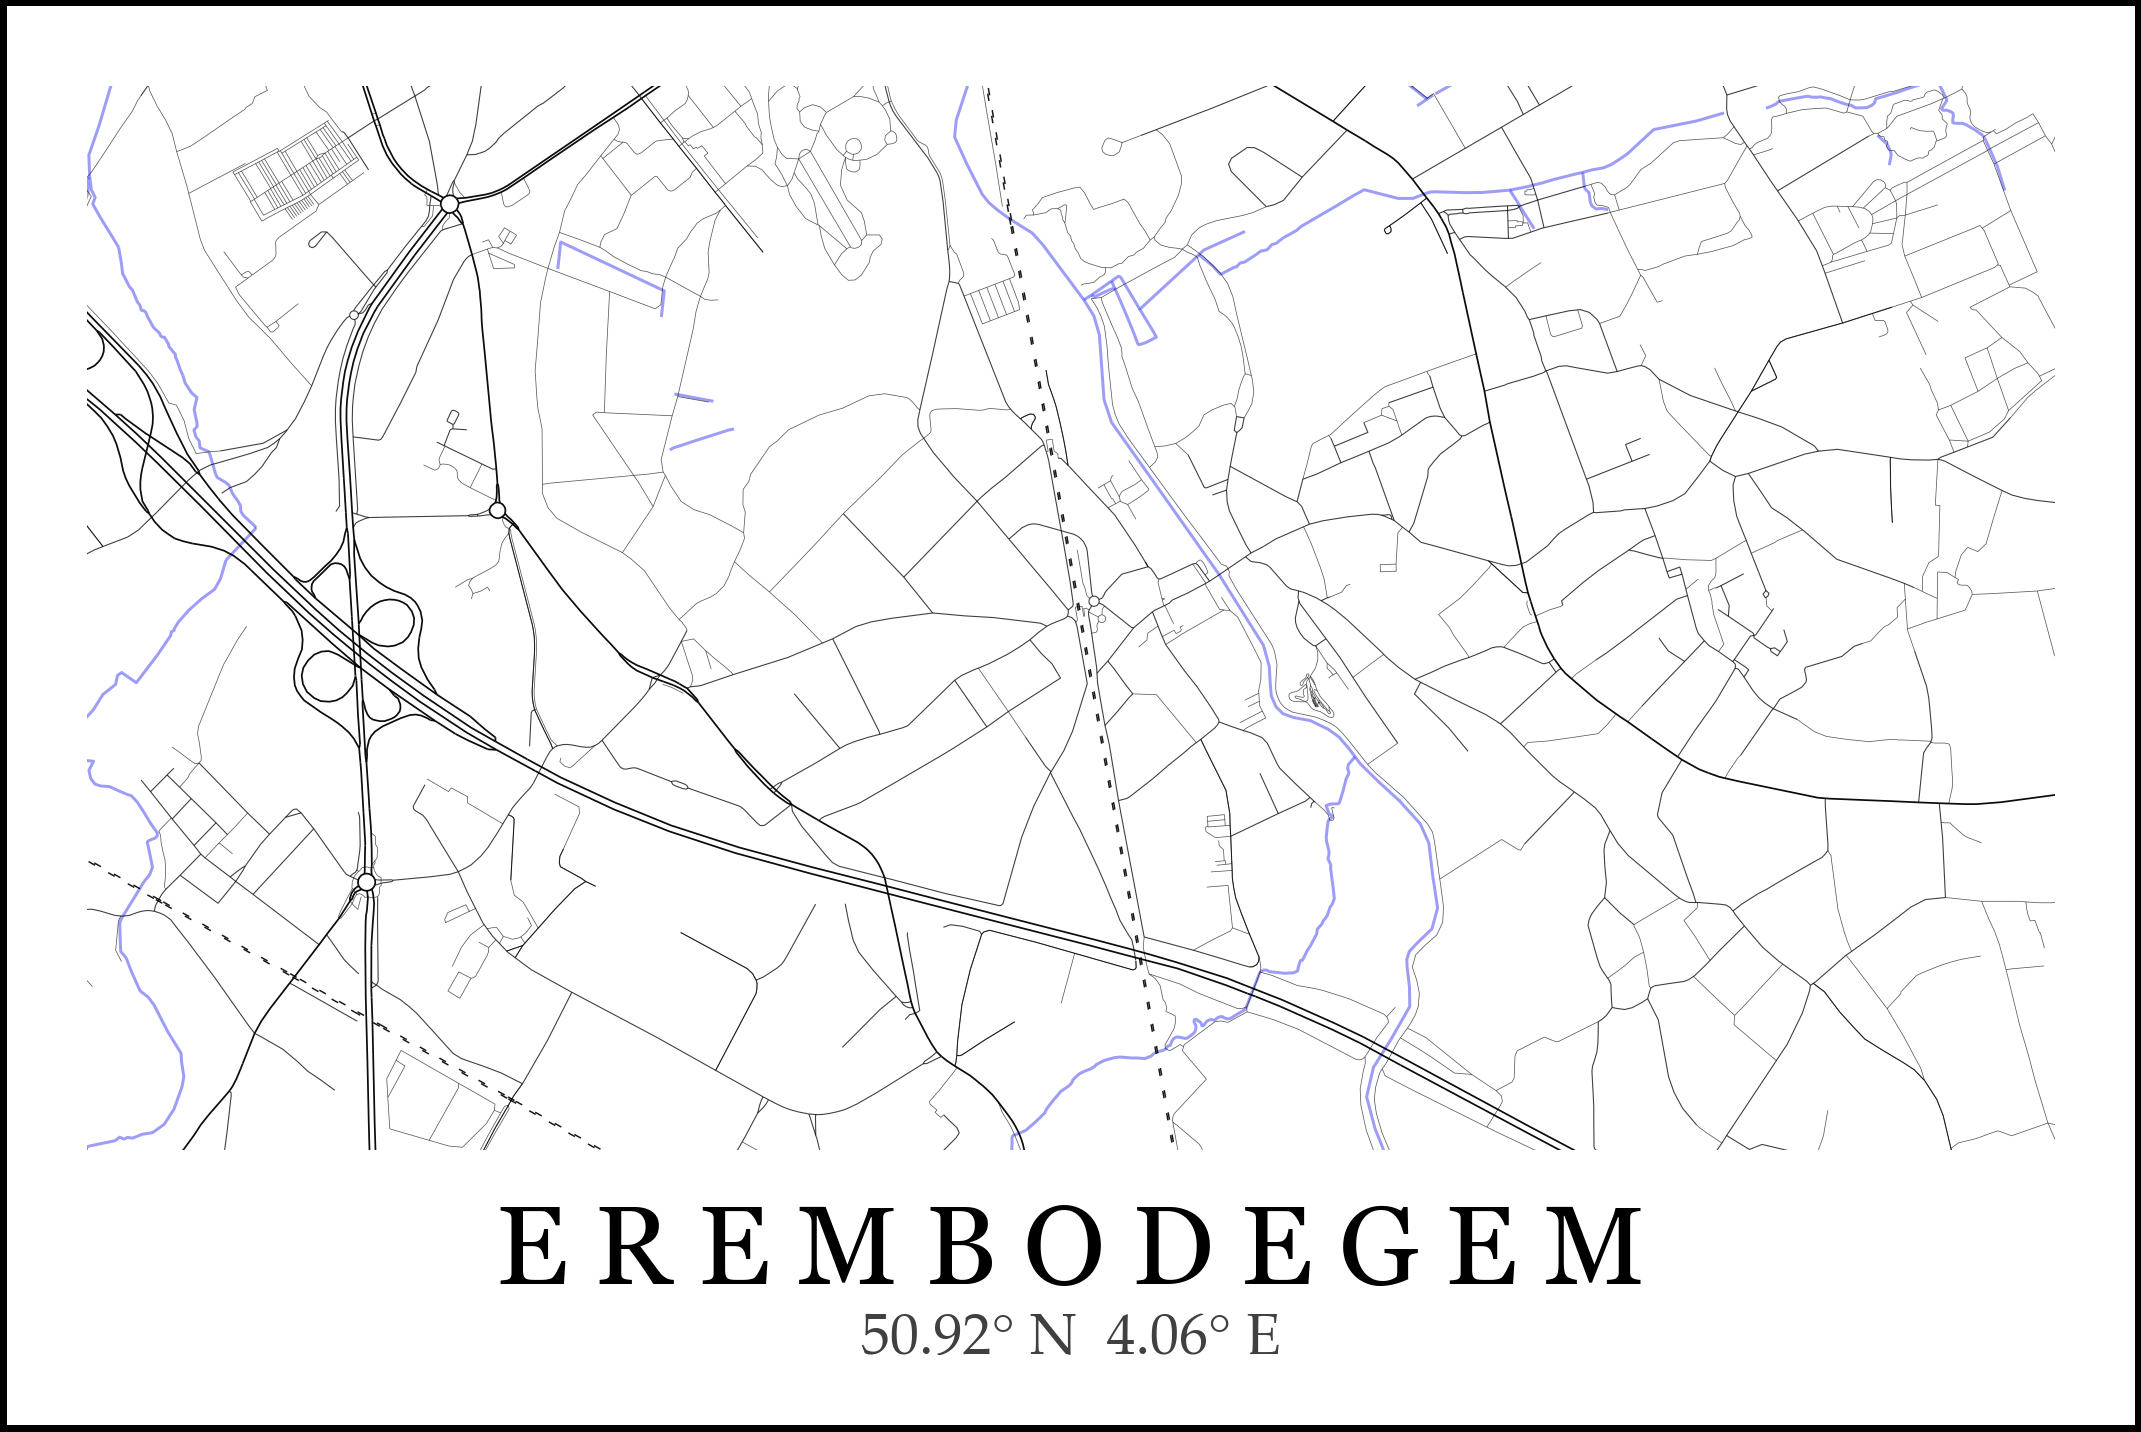

In [24]:
for i, locatie in enumerate(locaties):
    # i is the index
    # locatie is the place name
    center = locaties[locatie]['center']
    zoom_factor = locaties[locatie]['zoom_factor']/2.2
    orientation = locaties[locatie]['orientation']
    title = locaties[locatie]['title']

    # Set width and height
    if orientation == 'landscape':
        width, height = 3000, 2000
    elif orientation == 'portrait':
        width, height = 2000, 3000

    # Get center coordinates of the place
    x_wgs84 = center[0]
    y_wgs84 = center[1]
    x_lb72, y_lb72 = transformer.transform(x_wgs84,y_wgs84)

 
    #########################################
    ### Read OSM-file
    #########################################
    # Read [locatie].osm file
    data = driver.Open("./data/{0}.osm".format(locatie))

    #layer_points = data.GetLayer('points')
    layer_lines = data.GetLayer('lines')
    #layer_multilinestrings = data.GetLayer('multilinestrings')
    #layer_multipolygons = data.GetLayer('multipolygons')
    #layer_other_relations = data.GetLayer('other_relations')

    line_features = [x for x in layer_lines]

    # Convert to a gpd dataframe

    street_list=[]
    for feature in line_features: ## remove the [0] after test

        data=feature.ExportToJson(as_object=True)
        #print(data)

        coords=data['geometry']['coordinates']
        shapely_geo=LineString([coords[i] for i in range(len(coords))])

        # osm_id=data['properties']['osm_id']
        # name=data['properties']['name']
        highway=data['properties']['highway']
        waterway=data['properties']['waterway']

        other_tags=data['properties']['other_tags']
        if other_tags and 'railway' in other_tags:
            feat=[x for x in other_tags.split(',') if 'railway' in x][0]
            railway=feat[feat.rfind('>')+2:feat.rfind('"')]
        else:
            railway=None

#        street_list.append([osm_id, name, highway, waterway, railway, shapely_geo])
        street_list.append([highway, railway, waterway, shapely_geo])

#    gdf=gpd.GeoDataFrame(street_list,columns=['osm_id','name','highway','waterway','railway', 'geometry'],crs=inProj).to_crs(outProj)
    gdf=gpd.GeoDataFrame(street_list,columns=['highway','railway', 'waterway', 'geometry'],crs=inProj).to_crs(outProj)

    # Prepare the geodataframes for each theme (roads, water, rail)
    # Roads
    gdf.highway.unique() ## number of road types
    road_1 = gdf[gdf.highway.isin(['motorway', 'motorway_link', 'trunk', 'trunk_link', 'primary', 'primary_link', 'secondary', 'secondary_link'])]
    #road_1.plot(figsize=(15, 10), color='black').axis('off')

    road_2 = gdf[gdf.highway.isin(['tertiary', 'tertiary_link', 'unclassified', 'residential'])]
    #road_2.plot(figsize=(15, 10), color='black').axis('off')

    road_3 = gdf[gdf.highway.isin(['living_street','unclassified','service','footway','road', 'track', 'path', 'pedestrian', 'cycleway', 'footway', 'steps', 'platform'])]
    #road_3.plot(figsize=(15, 10), color='black').axis('off')

    # Water
    gdf.waterway.unique()
    #water = gdf[gdf.waterway.isin(['stream', 'river', 'ditch'])]
    water = gdf[gdf.waterway.isin(['stream', 'river'])]
    #water.plot(figsize=(15, 10), color='blue').axis('off')

    # Railway
    gdf.railway.unique()
    rail = gdf[gdf.railway == 'rail']
    #rail.plot(figsize=(15, 10), color='grey').axis('off')

 
    #########################################
    ### Plot figure
    #########################################

    fig, ax = plt.subplots(figsize=(width/100,height/100), edgecolor='k', linewidth=30, frameon=True)  ## Create one figure and one axes object

    # Remove redundant Axes elements
    # Remove x and y axis
    ax.set_xticks([])
    ax.set_yticks([])

    # Remove the box around the Axes object
    ax.set_frame_on(False)

    # Plot layers on one figure
    # plot waterways
    water.plot(ax=ax, color=(0.24,0.24,0.95,0.5), linewidth=3, zorder=1)

    # plot railways
    rail.plot(ax=ax, color=(0,0, 0,0.9), linestyle=(0,(5,10)), linewidth=1.5, zorder=5)

    # Plot roads
    #road_3.plot(ax=ax, color=(0,0,0,0.35), linewidth=0.55, zorder=2)  ## Gemeenten
    road_3.plot(ax=ax, color=(0,0,0,0.65), linewidth=0.75, zorder=2)  ## Stad
    
    road_2.plot(ax=ax, color=(0,0,0,0.75), linewidth=1.10, zorder=3)
    road_1.plot(ax=ax, color=(0,0,0,0.95), linewidth=1.75, zorder=4)

    # Zoom to a certain bbox extent
    # Set the (new) boundaries of the Axes object (zoom)
    x_min = x_lb72-(zoom_factor*width)
    x_max = x_lb72+(zoom_factor*width)

    y_min = y_lb72-(zoom_factor*height)
    y_max = y_lb72+(zoom_factor*height)

    x_pos_title = x_lb72
    y_pos_title = y_min + (y_max-y_min)*0.10
    x_pos_subtitle = x_lb72
    y_pos_subtitle = y_min + (y_max-y_min)*0.05

    # Set bounds
    ax.set_xbound(x_min, x_max)
    ax.set_ybound(y_min, y_max)

    # Add a patch to the Axes object
    rectangle_border = patches.Rectangle((x_min, y_min),2*width*zoom_factor,2*height*zoom_factor,linewidth=160,edgecolor='w',facecolor='none', zorder=7)
    ax.add_patch(rectangle_border)
    # Set footer based on the orientation of the map
    if orientation == 'portrait':
        rectangle_footer = patches.Rectangle((x_min, y_min),2*width*zoom_factor,0.32*height*zoom_factor,linewidth=10,edgecolor='w',facecolor='white', zorder=7)
    if orientation == 'landscape':
        rectangle_footer = patches.Rectangle((x_min, y_min),2*width*zoom_factor,0.38*height*zoom_factor,linewidth=10,edgecolor='w',facecolor='white', zorder=7)  
    ax.add_patch(rectangle_footer)


    # Add a title on the bottom of the map
    fontdict_title = {'family':'Georgia','fontsize':110,'verticalalignment':'baseline','horizontalalignment':'center'}
    fontdict_subtitle = {'family':'Palatino Linotype','fontsize':58,'verticalalignment':'baseline','horizontalalignment':'center'}

    #ax.set_xlabel('X-label')
    # ax.set_title('--------  {0}  --------'.format(locatie), fontdict=fontdict, backgroundcolor=(1,1,1,0.85), y=0.05)
    ax.text(x_pos_title, y_pos_title, '{0}'.format(title),fontdict=fontdict_title,zorder=8)
    ax.text(x_pos_subtitle, y_pos_subtitle, '{0}° N  {1}° E'.format(round(x_wgs84,2),round(y_wgs84,2)),fontdict=fontdict_subtitle, color='k', alpha=0.75, zorder=8)

    ## loc='center', pad=-(height)
    fig.tight_layout()
    #fig
    
    #########################################
    ### Write figure
    #########################################
    fig.savefig('./output/{0}.svg'.format(locatie))
    fig.savefig('./output/{0}.png'.format(locatie), dpi=300)
    
    fig.savefig('./output/{0}.jpg'.format(locatie), dpi=300)